## Compute topological barcodes for Week 3 data using RIPSER

- Authors: Zachary Neronha and Dhananjay Bhaskar
- Last Modified: 8 MAR (ZN) 
- Wong Lab, Brown University

#### Load required packages

In [1]:
library(TDA)
library(grid)
library(repr)
library(pracma)
library(stringr)
library(extrafont)
library(latex2exp)
library(Cairo)

library("ripserr")
library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

Registering fonts with R
Welcome to ripserr.


[1] "serif"                      "sans"                      
 [3] "mono"                       "AvantGarde"                
 [5] "Bookman"                    "Courier"                   
 [7] "Helvetica"                  "Helvetica-Narrow"          
 [9] "NewCenturySchoolbook"       "Palatino"                  
[11] "Times"                      "URWGothic"                 
[13] "URWBookman"                 "NimbusMon"                 
[15] "NimbusSan"                  "URWHelvetica"              
[17] "NimbusSanCond"              "CenturySch"                
[19] "URWPalladio"                "NimbusRom"                 
[21] "URWTimes"                   "ArialMT"                   
[23] "ComputerModern"             "ComputerModernItalic"      
[25] "Japan1"                     "Japan1HeiMin"              
[27] "Japan1GothicBBB"            "Japan1Ryumin"              
[29] "Korea1"                     "Korea1deb"                 
[31] "CNS1"                       "GB1"                       
[33] "Amiri"                      "Amiri Quran"               
[35] "Carlito"                    "DejaVu Sans"               
[37] "DejaVu Sans Condensed"      "DejaVu Sans Light"         
[39] "DejaVu Sans Mono"           "DejaVu Serif"              
[41] "DejaVu Serif Condensed"     "EB Garamond 08"            
[43] "EB Garamond 08 SC"          "EB Garamond 12"            
[45] "EB Garamond Initials Fill1" "EB Garamond Initials Fill2"
[47] "FontAwesome"                "FreeMono"                  
[49] "FreeSans"                   "FreeSerif"                 
[51] "Gentium"                    "GentiumAlt"                
[53] "Gentium Basic"              "Gentium Book Basic"        
[55] "Gentium Plus"               "IPAexGothic"               
[57] "IPAexMincho"                "IPAGothic"                 
[59] "IPAMincho"                  "IPAPGothic"                
[61] "IPAPMincho"                 "Junicode"                  
[63] "Lato Black"                 "Lato"                      
[65] "Lato Hairline"              "Lato Heavy"                
[67] "Lato Light"                 "Lato Medium"               
[69] "Lato Semibold"              "Lato Thin"                 
[71] "Liberation Mono"            "Liberation Sans"           
[73] "Liberation Sans Narrow"     "Liberation Serif"          
[75] "Myriad Pro"                 "CM Roman"                  
[77] "CM Roman Asian"             "CM Roman CE"               
[79] "CM Roman Cyrillic"          "CM Roman Greek"            
[81] "CM Sans"                    "CM Sans Asian"             
[83] "CM Sans CE"                 "CM Sans Cyrillic"          
[85] "CM Sans Greek"              "CM Symbol"                 
[87] "CM Typewriter"              "CM Typewriter Asian"       
[89] "CM Typewriter CE"           "CM Typewriter Cyrillic"    
[91] "CM Typewriter Greek"

#### Ripser loading and binding

In [2]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

#### Custom plotting functions

In [3]:
px2um = 1.0

dim0barcode = function(dimintervals, max_x_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0, 1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = "darkblue", size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                         color = "darkblue", size = 0.8)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 0.8)
    
    g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

dim1barcode = function(dimintervals, x_min_lim, x_max_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0,1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = 'red', size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = 'red', size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat),
                         color = 'red', size = 0.8)
    
    g = g + ylab(TeX('$\\beta_1$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(x_min_lim, x_max_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = px2um * dim1intervals[,2]
        d1mat = px2um * dim1intervals[,3]

        #g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 0.5)
        #g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 0.5)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 0.8)
    }
    
    b0mat = px2um * dim0intervals[,2]
    d0mat = px2um * dim0intervals[,3]
    
    #g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 0.5)
    #g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 0.8)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 0.8)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}


persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = px2um * dim0intervals[,2]
    beta0_dmat = px2um * dim0intervals[,3]
    
    beta1_bmat = px2um * dim1intervals[,2]
    beta1_dmat = px2um * dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 0.25)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 18, family = "Myriad Pro"),
                axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"), 
                axis.text.y = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    plot(p)
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

### Calculate Betti numbers for well A08 (2D)

In [ ]:
d3 = read.csv('Wk3_IMS_TDA/TDAready_a08.csv', header = FALSE)
d3 = d3[,1:2]
dat_A08 = data.matrix(d3)

In [ ]:
homology2_A08 <- ripserDiag(dat_A08, 1, 500)
intervals_A08 = as.data.frame(homology2_A08)
dim0_A08 = intervals_A08[intervals_A08$dimension==0,]
dim1_A08 = intervals_A08[intervals_A08$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

plot(d3[,1], d3[,2], xlab="", ylab="", mar=c(2,2,2,2), xaxt='n', yaxt='n')
TDA::plot.diagram(homology2_A08, barcode = FALSE)
TDA::plot.diagram(homology2_A08, barcode = TRUE)

In [ ]:
p1 = dim0barcode(dim0_A08, 200)
p2 = dim1barcode(dim1_A08, 5, 200)
p3 = persistencediag(dim0_A08, dim1_A08, 200)
p4 = combinedbarcode(dim0_A08, dim1_A08, 200)

saveepsfig(p1, 8, 4, "A08 Epithelial Betti 0", "Myriad Pro", "A08_Epithelial_Betti0.eps")

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

In [ ]:
saveepsfig(p1, 4.4, 4.4, "A08 Epithelial Betti 0", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Betti0.eps")
saveepsfig(p2, 4.4, 4.4, "A08 Epithelial Betti 1", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Betti1.eps")
saveepsfig(p3, 4.4, 4.4, "A08 Epithelial Persistence Diagram", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_PersistencePlot.eps")
saveepsfig(p4, 4.4, 4.4, "A08 Epithelial Barcode", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Barcode.eps")

### Calculate Betti numbers for well A09

In [ ]:
d4 = read.csv('Wk3_IMS_TDA/TDAready_a09.csv', header = FALSE)
d4 = d4[,1:2]
dat_A09 = data.matrix(d4)

In [ ]:
homology2_A09 <- ripserDiag(dat_A09, 1, 500)
intervals_A09 = as.data.frame(homology2_A09)
dim0_A09 = intervals_A09[intervals_A09$dimension==0,]
dim1_A09 = intervals_A09[intervals_A09$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

plot(d4[,1], d4[,2], xlab="", ylab="", mar=c(2,2,2,2), xaxt='n', yaxt='n')
TDA::plot.diagram(homology2_A09, barcode = FALSE)
TDA::plot.diagram(homology2_A09, barcode = TRUE)

In [ ]:
p1 = dim0barcode(dim0_A09, 200)
p2 = dim1barcode(dim1_A09, 5, 200)
p3 = persistencediag(dim0_A09, dim1_A09, 200)
p4 = combinedbarcode(dim0_A09, dim1_A09, 200)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

In [ ]:
saveepsfig(p1, 4.4, 4.4, "A09 Epithelial Betti 0", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A09_Pind_Betti0.eps")
saveepsfig(p2, 4.4, 4.4, "A09 Epithelial Betti 1", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A09_Pind_Betti1.eps")
saveepsfig(p3, 4.4, 4.4, "A09 Epithelial Persistence Diagram", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A09_Pind_PersistencePlot.eps")
saveepsfig(p4, 4.4, 4.4, "A09 Epithelial Barcode", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A09_Pind_Barcode.eps")

## Now look at 3D data for individual clusters

### Calculate Betti numbers for well A07 3D

In [ ]:
d = read.csv('Wk3_IMS_TDA/TDAready_a07.csv', header = FALSE)
dat_A07 = data.matrix(d)

In [ ]:
homology2_A07 <- ripserDiag(dat_A07, 1, 500)
intervals_A07 = as.data.frame(homology2_A07)
dim0_A07 = intervals_A07[intervals_A07$dimension==0,]
dim1_A07 = intervals_A07[intervals_A07$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

scatterplot3d(dat_A07, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks=FALSE, mar=c(2,2,2,2))
TDA::plot.diagram(homology2_A07, barcode = FALSE)
TDA::plot.diagram(homology2_A07, barcode = TRUE)

In [ ]:
p1 = dim0barcode(dim0_A07, 30)
p2 = dim1barcode(dim1_A07, 5, 30)
p3 = persistencediag(dim0_A07, dim1_A07, 30)
p4 = combinedbarcode(dim0_A07, dim1_A07, 30)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Calculate Betti numbers for well B11 3D

In [ ]:
d = read.csv('Wk3_IMS_TDA/TDAready_b11.csv', header = FALSE)
dat_B11 = data.matrix(d)

In [ ]:
homology2_B11 <- ripserDiag(dat_B11, 1, 500)
intervals_B11 = as.data.frame(homology2_B11)
dim0_B11 = intervals_B11[intervals_B11$dimension==0,]
dim1_B11 = intervals_B11[intervals_B11$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

scatterplot3d(dat_B11, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks=FALSE, mar=c(2,2,2,2))
TDA::plot.diagram(homology2_B11, barcode = FALSE)
TDA::plot.diagram(homology2_B11, barcode = TRUE)

In [ ]:
p1 = dim0barcode(dim0_B11, 100)
p2 = dim1barcode(dim1_B11, 5, 100)
p3 = persistencediag(dim0_B11, dim1_B11, 100)
p4 = combinedbarcode(dim0_B11, dim1_B11, 100)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Calculate Betti numbers for well G09 3D

In [ ]:
d = read.csv('Wk3_IMS_TDA/TDAready_g09.csv', header = FALSE)
dat_G09 = data.matrix(d)

In [ ]:
homology2_G09 <- ripserDiag(dat_G09, 1, 500)
intervals_G09 = as.data.frame(homology2_G09)
dim0_G09 = intervals_G09[intervals_G09$dimension==0,]
dim1_G09 = intervals_G09[intervals_G09$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

scatterplot3d(dat_G09, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks=FALSE, mar=c(2,2,2,2))
TDA::plot.diagram(homology2_G09, barcode = FALSE)
TDA::plot.diagram(homology2_G09, barcode = TRUE)

In [ ]:
p1 = dim0barcode(dim0_G09, 130)
p2 = dim1barcode(dim1_G09, 5, 130)
p3 = persistencediag(dim0_G09, dim1_G09, 130)
p4 = combinedbarcode(dim0_G09, dim1_G09, 130)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

## Implementation of Collective Well Data
- Looped implementation over all wells from week three timepoint
- Contains data from drugged and control conditions

#### Alpha Value Diagrams Batched

ERROR: Error in data.matrix(1, 2, 3, 4, 5, 0): unused arguments (3, 4, 5, 0)


       dimension Birth        Death
  [1,]         0     0     5.607894
  [2,]         0     0     6.205625
  [3,]         0     0     7.308164
  [4,]         0     0     7.713225
  [5,]         0     0     7.963425
  [6,]         0     0     8.277725
  [7,]         0     0     8.950396
  [8,]         0     0    10.098225
  [9,]         0     0    10.425581
 [10,]         0     0    10.450800
 [11,]         0     0    11.366961
 [12,]         0     0    11.608849
 [13,]         0     0    12.228870
 [14,]         0     0    12.474997
 [15,]         0     0    12.882600
 [16,]         0     0    13.304391
 [17,]         0     0    13.613722
 [18,]         0     0    13.630732
 [19,]         0     0    13.737577
 [20,]         0     0    13.947333
 [21,]         0     0    14.114113
 [22,]         0     0    14.265015
 [23,]         0     0    14.620125
 [24,]         0     0    14.712327
 [25,]         0     0    14.852725
 [26,]         0     0    15.364341
 [27,]         0     0    15

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

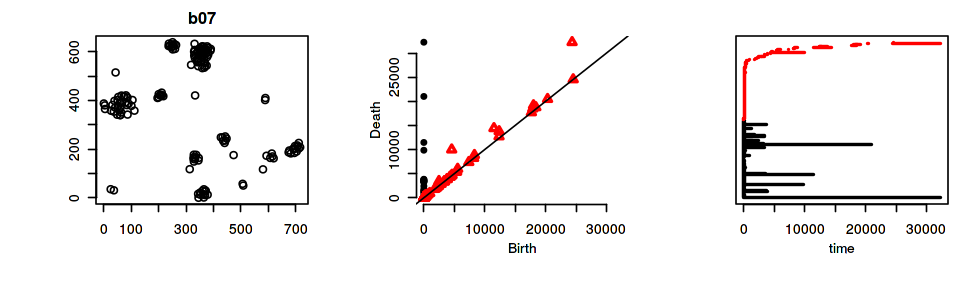

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_segment).”

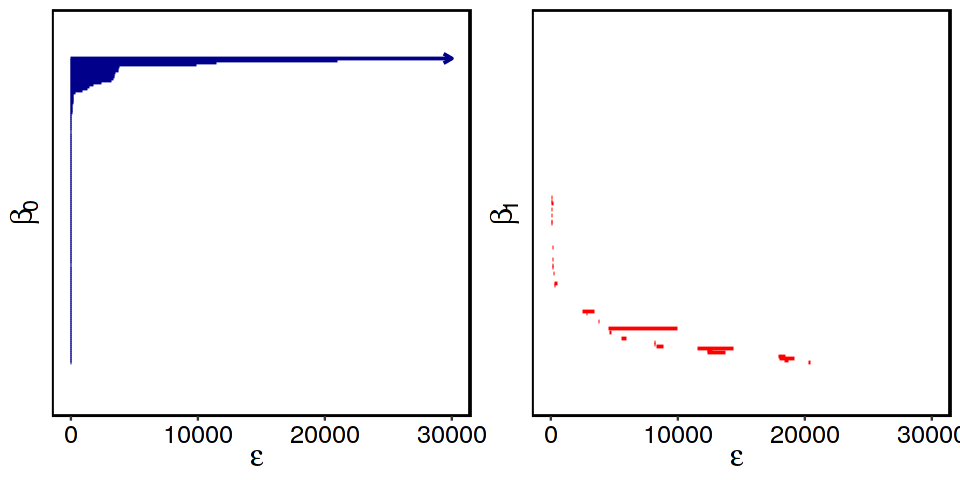

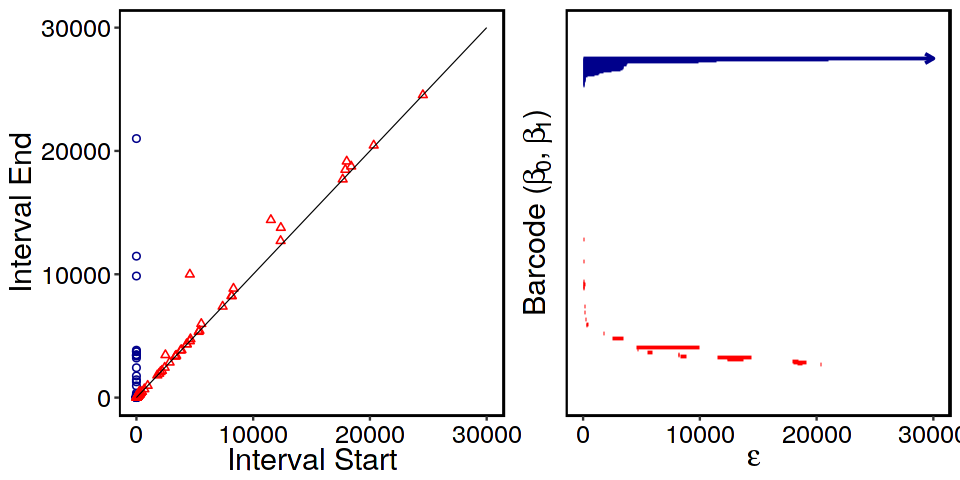

In [111]:
#Locate the converted files
folder = "Wk3_IMS_TDA/ExportImaris"
out_folder = "Wk3_IMS_TDA/Alph_Output_Files/"
g = list.files(path=folder,pattern="*b07.csv")
plot_size = 30000

for (well in g){
    #extract the well number
    num_well = strsplit(well,"_")
    num_well = num_well[[1]][2]
    num_well = substring(num_well,1,3)
    #print(num_well)
    
    #form string of interest
    readstring = paste(folder,"/",well,sep="")
    #read in the file of interest
    dframe = read.csv(readstring, header = FALSE)
#     dframe = dframe[,1:2]
    dat = data.matrix(dframe)
    
    #rescale the data by subtracting off the lowest value
    dat[,1] = dat[,1]-min(dat[,1])
    dat[,2] = dat[,2]-min(dat[,2])
    
#     dat = dat[1:5,]
    
    DiagAlphaCmplx = alphaComplexDiag(dat, maxdimension = 1, library = c("GUDHI","DIONYSUS"),location = TRUE, printProgress = FALSE)
    
    
    dim0 = DiagAlphaCmplx$diagram[DiagAlphaCmplx$diagram[,1]==0,]
    dim1 = DiagAlphaCmplx$diagram[DiagAlphaCmplx$diagram[,1]==1,]
    
    #reorder values for plotting
    dim0 = dim0[order(dim0[,2],dim0[,3]),]
    dim1 = dim1[order(-dim1[,2],-dim1[,3]),]
    print(dim0)
    print(dim1)
    
    par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
    options(repr.plot.width=8,repr.plot.height=2.5)

    plot(dat[,1], dat[,2], xlab="", ylab="", mar=c(2,2,2,2))
    title(main = num_well)
    TDA::plot.diagram(DiagAlphaCmplx$diagram, barcode = FALSE)
    TDA::plot.diagram(DiagAlphaCmplx$diagram, barcode = TRUE)
    
    
    dim0_finite = dim0[1:(length(dim0[,1])-1),]
    
    if (dim0[length(dim0[,1]),3]!=Inf){
        print("FAILURE IN INF BARCODE!!!")
        break
    }
    
    
    p1 = dim0barcode(dim0_finite, plot_size)
    p2 = dim1barcode(dim1, 5, plot_size)
    p3 = persistencediag(dim0_finite, dim1, plot_size)
    p4 = combinedbarcode(dim0_finite, dim1, plot_size)
    
    grid.newpage()
    options(repr.plot.width = 8, repr.plot.height = 4)
    grid.newpage()
    grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
    grid.newpage()
    grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))
    grid.newpage()
    
    
#     saveepsfig(p1, 4.4, 4.4, paste(num_well,"Betti 0",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Betti0.eps",sep=""))
#     saveepsfig(p2, 4.4, 4.4, paste(num_well,"Betti 1",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Betti1.eps",sep=""))
#     saveepsfig(p3, 4.4, 4.4, paste(num_well,"Persistence Diagram",sep=" "), "Myriad Pro", paste(out_folder,num_well,"PersistencePlot.eps",sep=""))
#     saveepsfig(p4, 4.4, 4.4, paste(num_well,"Barcode",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Barcode.eps",sep=""))

}

In [39]:
sorted_death_eps = sort(DiagAlphaCmplx$diagram[,3], index.return=TRUE)$x
sorted_death_indices = sort(DiagAlphaCmplx$diagram[,3], index.return=TRUE)$ix

length(sorted_death_indices)
#print(DiagAlphaCmplx)

[1] 277

$diagram
       dimension       Birth        Death
  [1,]         0     0.00000          Inf
  [2,]         0     0.00000    50.530525
  [3,]         0     0.00000    33.871225
  [4,]         0     0.00000    18.933525
  [5,]         0     0.00000    29.972900
  [6,]         0     0.00000    33.614725
  [7,]         0     0.00000    17.071400
  [8,]         0     0.00000    14.074400
  [9,]         0     0.00000    12.584900
 [10,]         0     0.00000    17.926400
 [11,]         0     0.00000     3.288400
 [12,]         0     0.00000    23.182900
 [13,]         0     0.00000  3604.823125
 [14,]         0     0.00000    14.236900
 [15,]         0     0.00000  2256.645625
 [16,]         0     0.00000    40.542525
 [17,]         0     0.00000    40.167725
 [18,]         0     0.00000    19.328725
 [19,]         0     0.00000    32.366900
 [20,]         0     0.00000     5.100625
 [21,]         0     0.00000    20.181725
 [22,]         0     0.00000     7.152100
 [23,]         0     0.00

In [56]:
print(dim(DiagAlphaCmplx$cycleLocation[271][[1]])[2])

[1] 2


## TO DO
- Add diagram and synthetic example of alpha
- Rerun synthetic data with alpha
- 3D results
- Movie?
- What are the two biggest wells with a difference
- Crocker buisness, extract features/write to txt or csv
- Pick out three representative, Uninduced, preinduced, taxol (?) 
- Lumen nuclear tracking and extract parameters

dimension     Birth     Death 
   0.0000    0.0000  303.3685 
[[1]]
, , 1

       [,1]
[1,] 345.87
[2,] 313.24

, , 2

      [,1]
[1,] 163.6
[2,] 117.4




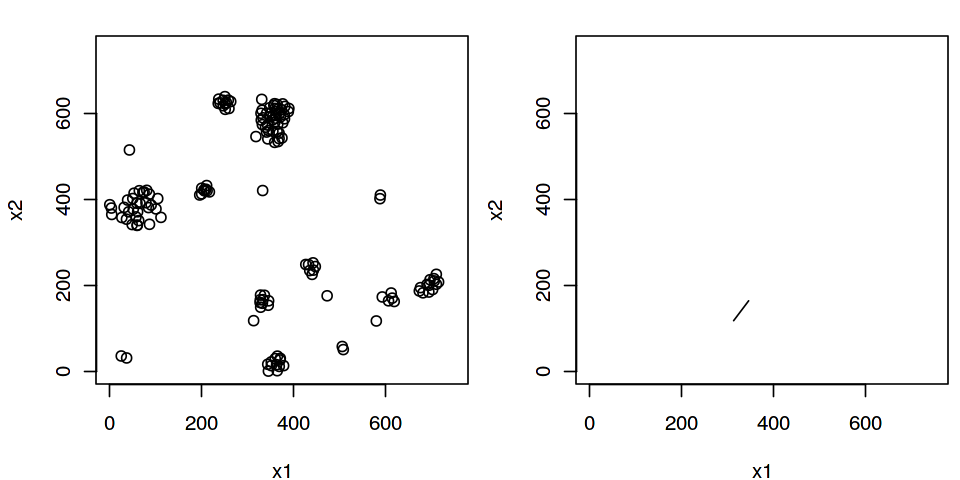

dimension     Birth     Death 
   0.0000    0.0000  726.6595 
[[1]]
, , 1

       [,1]
[1,] 580.37
[2,] 606.96

, , 2

      [,1]
[1,] 116.7
[2,] 163.6




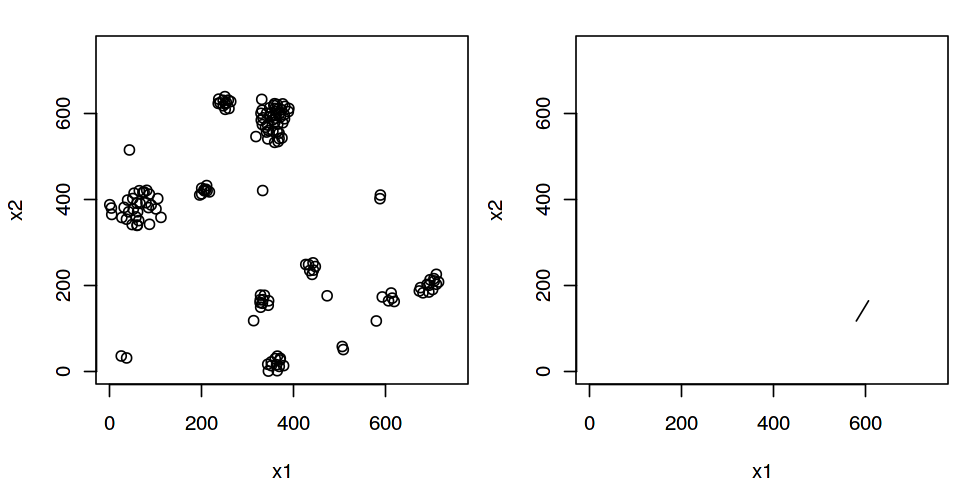

In [110]:
cnt = 0
for (i in seq(1, length(DiagAlphaCmplx$cycleLocation))){
    ind = sorted_death_indices[i]
    homology = dim(DiagAlphaCmplx$cycleLocation[ind][[1]])[2]


    if (homology == 1){
        cnt = cnt + 1
        if (cnt > 137 & cnt < 140){
            par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))
            options(repr.plot.width=8,repr.plot.height=4)
            plot(dat,xlab='x1',ylab='x2',xlim=c(0,750),ylim = c(0,750))
            plot(DiagAlphaCmplx$cycleLocation[ind][[1]][, ,1], DiagAlphaCmplx$cycleLocation[ind][[1]][, ,2],type = 'l', xlab='x1',ylab='x2',xlim=c(0,750),ylim = c(0,750))
            print(DiagAlphaCmplx$diagram[ind,])
            print(DiagAlphaCmplx$cycleLocation[ind])
        }
    }
    
}

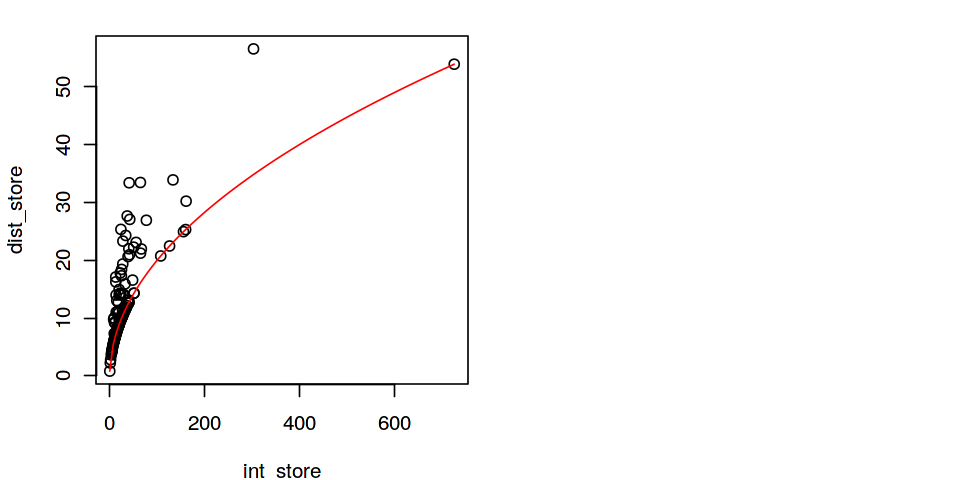

In [109]:
cnt = 0
int_store = c()
dist_store = c()
for (i in seq(1, length(DiagAlphaCmplx$cycleLocation))){
    ind = sorted_death_indices[i]
    homology = dim(DiagAlphaCmplx$cycleLocation[ind][[1]])[2]


    if (homology == 1){
        cnt = cnt + 1
        if (cnt < 140){
            par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))
            options(repr.plot.width=8,repr.plot.height=4)
            #plot(dat,xlab='x1',ylab='x2',xlim=c(0,750),ylim = c(0,750))
            #plot(DiagAlphaCmplx$cycleLocation[ind][[1]][, ,1], DiagAlphaCmplx$cycleLocation[ind][[1]][, ,2],type = 'l', xlab='x1',ylab='x2',xlim=c(0,750),ylim = c(0,750))
            int_len = DiagAlphaCmplx$diagram[ind,3]-DiagAlphaCmplx$diagram[ind,2] 
            x_dif = DiagAlphaCmplx$cycleLocation[ind][[1]][, , 1][1]-DiagAlphaCmplx$cycleLocation[ind][[1]][, , 1][2]
            y_dif = DiagAlphaCmplx$cycleLocation[ind][[1]][, , 2][1]-DiagAlphaCmplx$cycleLocation[ind][[1]][, , 2][2]
            sq_dist = (x_dif^2+y_dif^2)^(1/2)
            
            int_store = c(int_store,int_len)
            dist_store = c(dist_store,sq_dist)
        }
    }
    
}
#print(int_store)
#print(dist_store)
plot(int_store,dist_store)

curve(2*(x^(1/2)),add = TRUE,col="red")






#### Rips Complex Compuations Batched

Warning message:
“Removed 3 rows containing missing values (geom_segment).”Warning message:
“Removed 4 rows containing missing values (geom_segment).”

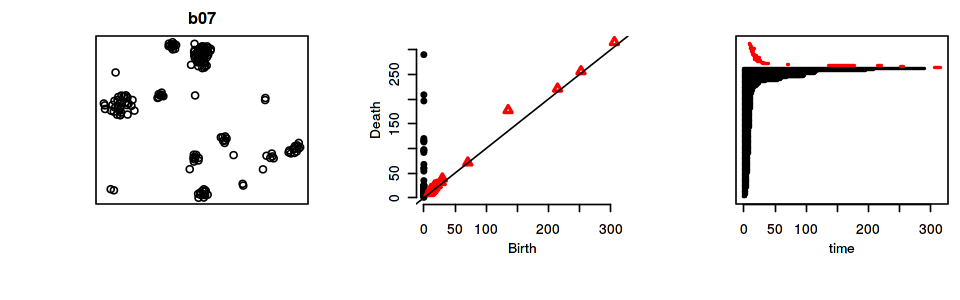

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_segment).”Warning message:
“Removed 3 rows containing missing values (geom_segment).”

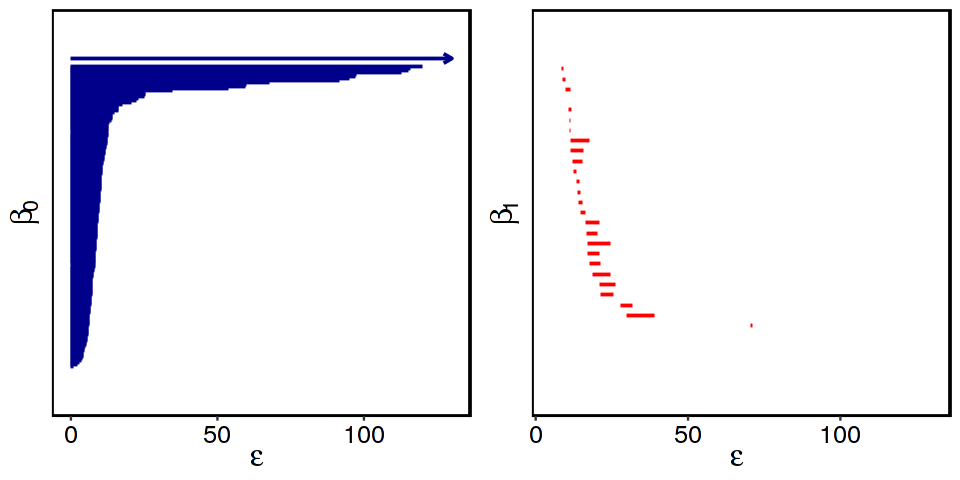

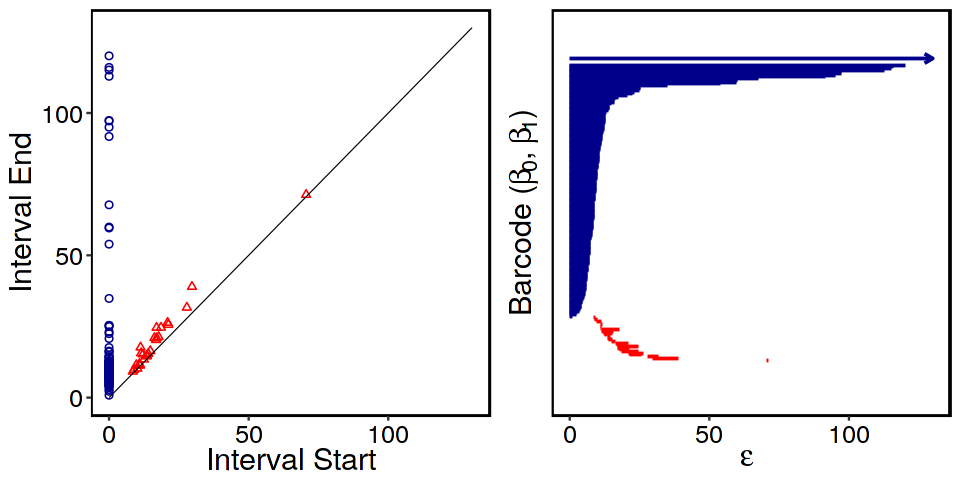

In [26]:
#Locate the converted files
folder = "Wk3_IMS_TDA/ExportImaris"
out_folder = "Wk3_IMS_TDA/Alph_Output_Files/"
g = list.files(path=folder,pattern="*b07.csv")

for (well in g){
    #extract the well number
    num_well = strsplit(well,"_")
    num_well = num_well[[1]][2]
    num_well = substring(num_well,1,3)
    #print(num_well)
    
    #form string of interest
    readstring = paste(folder,"/",well,sep="")
    #read in the file of interest
    dframe = read.csv(readstring, header = FALSE)
    dframe = dframe[,1:2]
    dat = data.matrix(dframe)
    
    homology2 <- ripserDiag(dat, 1, 10000)
    intervals = as.data.frame(homology2)
    dim0 = intervals[intervals$dimension==0,]
    dim1 = intervals[intervals$dimension==1,]

    par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
    options(repr.plot.width=8,repr.plot.height=2.5)

    plot(dframe[,1], dframe[,2], xlab="", ylab="", mar=c(2,2,2,2), xaxt='n', yaxt='n')
    title(main = num_well)
    TDA::plot.diagram(homology2, barcode = FALSE)
    TDA::plot.diagram(homology2, barcode = TRUE)
    
    p1 = dim0barcode(dim0, 130)
    p2 = dim1barcode(dim1, 5, 130)
    p3 = persistencediag(dim0, dim1, 130)
    p4 = combinedbarcode(dim0, dim1, 130)
    
    grid.newpage()
    options(repr.plot.width = 8, repr.plot.height = 4)
    grid.newpage()
    grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
    grid.newpage()
    grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))
    grid.newpage()
    
    
    #saveepsfig(p1, 4.4, 4.4, paste(num_well,"Betti 0",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Betti0.eps",sep=""))
    #saveepsfig(p2, 4.4, 4.4, paste(num_well,"Betti 1",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Betti1.eps",sep=""))
    #saveepsfig(p3, 4.4, 4.4, paste(num_well,"Persistence Diagram",sep=" "), "Myriad Pro", paste(out_folder,num_well,"PersistencePlot.eps",sep=""))
    #saveepsfig(p4, 4.4, 4.4, paste(num_well,"Barcode",sep=" "), "Myriad Pro", paste(out_folder,num_well,"Barcode.eps",sep=""))

}